# 88_군집을 이용한 이미지 분할

# 이미지 분할 image segmentation
- 이미지 분할은 `이미지를 여러개로 분할`하는 것. // `색상 분할`을 이야기하는 것.
- 시맨틱 분할 (semantic segmentation)은 `동일 종류의 물체에 속한 픽셀을 같은 세그먼트로 할당`
- 시맨틱 분할에서 최고의 성능을 내려면 역시 `CNN 기반`으로
- 지금은 단순히 색상 분할로 시도

In [12]:
# 이미지 불러오기
import matplotlib.pyplot as plt
from matplotlib.image import imread
image = imread('/Users/newrandom/Documents/GitHub/ML_study/Zerobase_part09_머신러닝/Lecture_image/Koong_i.jpg')
image.shape

(740, 783, 3)

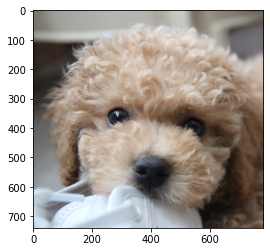

In [13]:
plt.imshow(image);

In [14]:
# 색상별로 클러스터링 하기
from sklearn.cluster import KMeans

X = image.reshape(-1, 3)
                    # 3 : rgb로 나눈다.
kmeans = KMeans(n_clusters=8, random_state=13).fit(X)
                # n_clusters : 색상을 8 개로 나눈다.
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
                        # 센터 값의 라벨을 저장할 것.
segmented_img = segmented_img.reshape(image.shape)


## 가장 많이 사용된 대표색상 8개를 뽑는다.

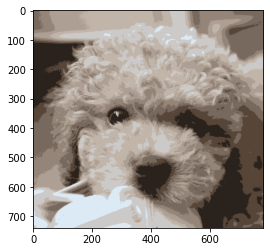

In [16]:
# 결과 - 색상의 종류가 단순해진다.
plt.imshow(segmented_img.astype('uint8'));
                        # Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). : 오류가 뜰 때, 
                        # astype('uint8') 옵션을 추가할 것.

In [17]:
# 이번에는 여러개의 군집을 비교
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=13).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

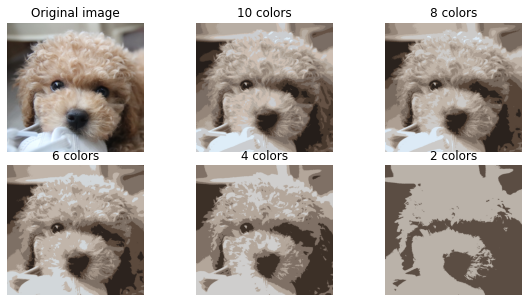

In [19]:
# 이번에는 좀 복잡하게 결과를 시각화
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx].astype('uint8'))
    plt.title('{} colors'.format(n_clusters))
    plt.axis('off')

plt.show()

----------------------

In [20]:
# MNIST 데이터 사용하기
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=13)

In [21]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class = 'ovr', solver='lbfgs', max_iter=5000, random_state=13)
                            # multi_class : 다중 분류이기 때문에 (0, 1로 나뉘는 게 아니기 때문에)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=13)

In [22]:
# 결과
log_reg.score(X_test, y_test)

0.9622222222222222

In [23]:
# pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50, random_state=13)),
                        # 784개의 픽셀을 50개로 줄임.
    ('log_reg', LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=13))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=13)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=13))])

In [24]:
pipeline.score(X_test, y_test)
# 약간 상승한다.

0.9688888888888889

In [25]:
# Gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
                        # pipeline을 가져오고
                                    # cluster의 개수를 2개부터 100개까지 나누는 작업을 진행
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.1s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=13)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=13))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [26]:
grid_clf.best_params_

# 82 번 클라스터가 좋다.

{'kmeans__n_clusters': 82}

In [27]:
grid_clf.score(X_test, y_test)
# 스코어가 좀 더 상승한다.

0.9755555555555555